<a href="https://colab.research.google.com/github/nori-sasa-dev/nori-sasa-dev.github.io/blob/main/%E3%82%B3%E3%83%BC%E3%83%87%E3%82%A3%E3%83%B3%E3%82%B0%E8%A9%A6%E9%A8%93Chapter2_%E5%86%99%E7%B5%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. MLP基礎

### 【Google colabのみ実行】ライブラリのインストール

In [1]:
import sys

# Google colab環境であるか判定
if "google.colab" in sys.modules:
    print("Google Colab")
    # ライブラリのインストール
    %pip install --no-warn-conflicts opencv-python==4.8.1.78
else:
    print("Not Google Colab")

Google Colab


### 【Google colabのみ実行】ドライブのマウント

In [2]:
import sys

# Google colab環境であるか判定
if "google.colab" in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount("/content/drive")
else:
    print("Not Google Colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ファイル操作

手持ちのデータをcolabで使用するには、データをGoogleドライブ内のフォルダに上げる必要があります。<br>

**画面左側のファイルマークのボタン**をクリックして、ドライブ内のファイルリストを開いてください。<br>

すると「drive」「sample_data」というフォルダがあり、「drive」がマイドライブや共有ドライブの入っているフォルダになります。<br>
<br>
この「drive」フォルダの中でアップロードしたい場所を選び、**右クリック(または3点リーダー「⋮」をクリック)から「アップロード」を押して**、今回使用するファイル<font color="Red">「train_data.csv」「test_data.csv」</font>をアップしましょう。<br>
<br>
アップロードしたファイルをコードの関数内で参照する際は右クリックで「パスをコピー」を選択し、コードに貼り付けましょう。<br>

## 回帰モデル試験（スクラッチ）

### データの準備

#### ライブラリのインポート


In [3]:
# Downgrade numpy to a version compatible with opencv-python 4.8.1.78
%pip install "numpy<2" --force-reinstall

  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


In [1]:
import csv
import os
import pickle
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.model_selection import train_test_split

%matplotlib inline
# "%matplotlib inline" の代わりに以下のコマンドを使用できる場合、3次元で座標軸を操作可能なプロットを表示することができます。
# %matplotlib notebook

# 乱数シードを指定
np.random.seed(seed=0)

#### データの３次元散布図を作成する関数

In [2]:
def plot_data(data, name="Data Plot"):
    """3D散布図を描画する関数

    Args:
        data (numpy.ndarray): 描画するデータのnumpy配列。各行は(x0, x1, y)の形式である必要があります。
        name (str, optional): グラフのタイトル。デフォルトは'Data Plot'です。

    """
    # グラフ作成
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")

    # 軸ラベルの設定
    ax.set_xlabel("X0-axis")
    ax.set_ylabel("X1-axis")
    ax.set_zlabel("Y-axis")

    # 表示範囲の設定
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(0, 10)

    ax.plot(data[:, 0], data[:, 1], data[:, 2], "o", color="#ff2222", ms=2, mew=0.5)
    ax.set_title(name)
    plt.show()

#### データの読み込み

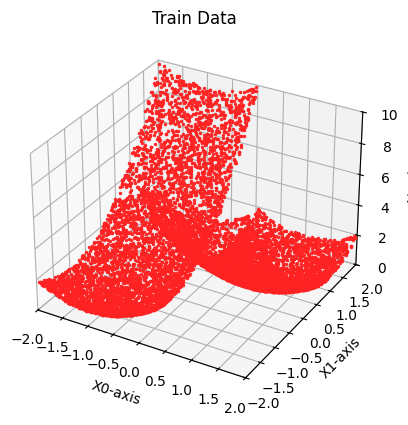

In [4]:
# Pathの設定
if "google.colab" in sys.modules:
    train_path = "/content/drive/MyDrive/E_Train/train_data.csv"
    test_path = "/content/drive/MyDrive/E_Train/test_data.csv"
else:
    train_path = "train_data.csv"
    test_path = "test_data.csv"

# データの読み込み
with open(train_path) as f:
    reader = csv.reader(f)
    train_data = np.array([[float(x) for x in row] for row in reader])
with open(test_path) as f:
    reader = csv.reader(f)
    test_data = np.array([[float(x) for x in row] for row in reader])

# 訓練データを可視化
plot_data(train_data, "Train Data")

#### データの数

In [5]:
N_train = train_data.shape[0]
print("訓練データの数: ", N_train)
N_test = test_data.shape[0]
print("テストデータの数: ", N_test)

訓練データの数:  10000
テストデータの数:  2000


### 活性化関数

#### ReLU関数

* <font color="Red">問1. ReLUを完成させてください。</font>

```
引数:
    v: [N, M] (np.float64)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float64)
```

- 以下の式で定義されるrelu関数を実装します。
$$ \text{ReLU}(x) = \left\{ \begin{array}{ll} x & (x \gt 0) \\ 0 & (x \leq 0) \end{array} \right. $$
- 引数`v`の各要素と0の大きい方を取り、`x`とします。
- ヒント: np.maximum()

In [6]:
def relu(v):
  x = np.maximum(0, v)
  return x

In [7]:
print(f"{relu(1) = }")
print(f"{relu(-2) = }")
print(f"{relu(0.1) = }")
print(f"{relu(-0.5) = }")

relu(1) = 1
relu(-2) = 0
relu(0.1) = 0.1
relu(-0.5) = 0.0


#### softmax関数

* <font color="Red">問2. softmax関数を完成させてください。</font>

```plaintext
引数:
    x: [N, M] (np.float64)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float64)
```

バッチ計算が可能なsoftmax関数を実装します。\
exp関数がオーバーフローすることを防ぐために、各データについて入力信号の最大値を引いて、0以下にします。\
numpyでは `[N, M] - [N]` の計算はブロードキャストができませんので、`x` を転置し `[M, N] - [N]` の形で計算を行ったあと、さらに転置をして元の形に戻します。

$$
\begin{align*}
  \text{Softmax}(x_{ij}) &= \frac{\exp (x_{ij}^{\prime})}{\sum_{k=1}^M \exp (x_{ik}^{\prime})} \\
  x_{ij}^\prime &= x_{ij} - \max_{j}(x_{ij})
\end{align*}
$$

In [8]:
# 転置あり
def softmax(x):
  x = x.T
  x = x - np.max(x, axis=0, keepdims=True)
  x = np.exp(x)
  x = x / np.sum(x, axis=0, keepdims=True)
  return x.T

In [9]:
# 転置なし
def softmax(x):
  x = x - np.max(x, axis=1, keepdims=True)
  exp_x = np.exp(x)
  return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [13]:
x = np.array([[2.0, 1.0, 0.1],
              [1.0, 3.0, 0.2]])
result = softmax(x)
print(result)

[[0.65900114 0.24243297 0.09856589]
 [0.11314284 0.8360188  0.05083836]]


# axis / keepdimsの使い方
axis=0 : 列方向  
axis=1 : 行方向  
  
keepdims=True : 計算後も元の次元を保持する  
keepdims=False: 計算後は次元が減る


In [10]:
# axis / keepdims 学習用コード
a = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
print(f"{np.max(a, axis=0, keepdims=True) = }")
print(f"{np.max(a, axis=1, keepdims=True) = }")

np.max(a, axis=0, keepdims=True) = array([[7, 8, 9]])
np.max(a, axis=1, keepdims=True) = array([[3],
       [6],
       [9]])


In [11]:
# axis / keepdims 学習用コード
a = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])
print(f"{np.max(a, axis=0, keepdims=False) = }")
print(f"{np.max(a, axis=1, keepdims=False) = }")

np.max(a, axis=0, keepdims=False) = array([7, 8, 9])
np.max(a, axis=1, keepdims=False) = array([3, 6, 9])


#### sigmoid関数
* <font color="Red">問3. sigmoid関数を完成させてください。</font>

```
引数:
    x: [N, M] (np.float64)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float64)
```

バッチ計算が可能なsigmoid関数を実装します。<br>

$$   \text{Sigmoid}(x) = \frac{1}{1 + \exp(-x)} $$

In [14]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [15]:
print(sigmoid(0))
print(sigmoid(9999))
print(sigmoid(-9999))

0.5
1.0
0.0


/tmp/ipython-input-449343092.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


In [16]:
sigmoid(np.array([-1, 0, 1]))

array([0.26894142, 0.5       , 0.73105858])

#### tanh関数
* <font color="Red">問4. tanh関数を完成させてください。</font>
  * <font color="Red">問4-1. tanh関数の分子にあたるsinh(双曲線正弦関数)の式を記述しましょう。</font>
  * <font color="Red">問4-2. tanh関数の分母にあたるcosh(双曲線余弦関数)の式を記述しましょう。</font>

```
引数:
    x: [N, M] (np.float64)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float64)
```

バッチ計算が可能なtanh関数を実装します。<br>
tanh関数は以下のように定義されている。<br>

$$   \text{tanh}(x) = \frac{\exp(x) - \exp(-x)}{\exp(x) + \exp(-x)} $$

tanh関数はハイパボリックタンジェントやタンエイチと読み、sinh関数とcosh関数を用いて以下のように書き直すことができる。

$$   \text{tanh}(x) = \frac{\text{sinh}(x) }{\text{cosh}(x) } $$

sinh関数はハイパボリックサインやシャイン、cosh関数はハイパボリックコサインやコッシュと読み、以下のように定義されている。

$$   \text{sinh}(x) = \frac{\exp(x) - \exp(-x)}{2} $$

$$   \text{cosh}(x) = \frac{\exp(x) + \exp(-x)}{2} $$

In [17]:
def tanh(x):
  sinh = (np.exp(x) - np.exp(-x)) / 2
  cosh = (np.exp(x) + np.exp(-x)) / 2
  return sinh / cosh

In [20]:
print(tanh(0))
print(tanh(100))
print(tanh(-100))

0.0
1.0
-1.0


#### Leaky ReLU関数

* <font color="Red">問5. Leaky ReLUを完成させてください。</font>

```
引数:
    x: [N, M] (np.float64)
       Nはバッチサイズにあたる
返値:
    [N, M] (np.float64)
```

- 以下の式で定義されるLeaky ReLU関数を実装します。

$$ \text{Leaky ReLU}(x,\alpha) = \left\{ \begin{array}{ll} x & (x \gt 0) \\ \alpha x & (x \leq 0) \end{array} \right. $$
- $\alpha$は定数。

In [21]:
def lrelu(x, alpha=0.01):
  x = np.maximum(alpha*x, x)
  return x

In [22]:
print(lrelu(-0.5))
print(lrelu(0.5))

-0.005
0.5
